In [2]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
# ntuple file here
file = uproot.open('/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/close_by_double_pion/production/ntuples_10454408_0.root')

In [4]:
file.keys()
file.classnames()

{'ntuplizer': 'TDirectory',
 'ntuplizer/simtrackstersSC': 'TTree',
 'ntuplizer/simtrackstersCP': 'TTree',
 'ntuplizer/tracksters': 'TTree',
 'ntuplizer/clusters': 'TTree',
 'ntuplizer/graph': 'TTree',
 'ntuplizer/candidates': 'TTree',
 'ntuplizer/trackstersMerged': 'TTree',
 'ntuplizer/associations': 'TTree',
 'ntuplizer/tracks': 'TTree'}

In [5]:
trackstersclue3d = file["ntuplizer/tracksters"]
simtrackstersCP = file["ntuplizer/simtrackstersCP"]
graph = file["ntuplizer/graph"]
associations = file["ntuplizer/associations"]
candidates = file["ntuplizer/candidates"]
#simtrackstersCP.show()

In [6]:
# Get ntuples from tree in file
tracksterN = trackstersclue3d["NTracksters"].array(library='np')
x = trackstersclue3d["barycenter_x"].array(library='np')
y = trackstersclue3d["barycenter_y"].array(library='np')
z = trackstersclue3d["barycenter_z"].array(library='np')
linkedInners = graph["linked_inners"].array(library='np')
linkedOuters = graph["linked_outers"].array(library='np')
trackstersInCandidate = candidates["tracksters_in_candidate"].array(library='np')
simTracksters_CP_N = simtrackstersCP["stsCP_NTracksters"].array(library='np')
tsAssocMap = associations["tsCLUE3D_recoToSim_CP"].array(library='np')
tsAssocQual = associations["tsCLUE3D_recoToSim_CP_score"].array(library='np')

In [7]:
# Print ntuples
event_to_visualize = 100
print("N tracksters (CLU3D): ", tracksterN[event_to_visualize])
#print("trackster indices: ", indices[event_to_visualize])
print("", z[event_to_visualize])
#print(linkedInners[event_to_visualize])
#print(linkedOuters[event_to_visualize])
print("ts in candidate:   ", trackstersInCandidate[event_to_visualize])
print("ts Reco-Sim assoc: ", tsAssocMap[event_to_visualize])
print("assoc quality:     ", tsAssocQual[event_to_visualize])
print("N SimTrackster (from CP):", simTracksters_CP_N[event_to_visualize])

N tracksters (CLU3D):  43
 [348.34076 363.09598 369.3865  373.74396 393.7238  385.6462  392.84073
 384.739   392.177   393.8887  388.72076 393.73834 390.2447  394.61102
 397.1836  408.28082 404.9629  404.93228 405.28772 405.72772 415.73474
 416.56924 430.83353 426.5108  431.45328 439.80377 427.66946 424.50476
 421.05435 430.783   437.0166  446.32397 434.65097 450.31485 469.56793
 469.54092 480.60065 485.5814  474.2869  478.9961  487.68015 490.8899
 507.6964 ]
ts in candidate:    [[0, 1, 2, 5, 19, 33], [3, 7, 12, 20, 21, 35, 14, 22, 29], ..., [38], [40]]
ts Reco-Sim assoc:  [[1, 0], [1, 0], [1, 0], [0, 1], [0, 1], ..., [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
assoc quality:      [[1.0, 8.341847e-07], [1.0, 0.0], ..., [1.0, 0.0], [1.0, 0.0]]
N SimTrackster (from CP): 2


In [8]:
# Truth graph
nodes_truth = []
edges_truth = []
ts_best_matches = []
assoc_threshold = 0.1
to_same = []

for i in range(tracksterN[event_to_visualize]):
    nodes_truth.append(i)
    assocToThis = tsAssocMap[event_to_visualize][i]
    assocQual = tsAssocQual[event_to_visualize][i]
    if np.size(assocToThis) > 0 and np.amin(assocQual) < assoc_threshold:
        ts_best_matches.append([i,assocToThis[np.argmin(assocQual)]])
    else:
        ts_best_matches.append([i,-1])

for st in range(simTracksters_CP_N[event_to_visualize]):
    to_same.append([])
print("Best matches [ts, sts]: ", ts_best_matches)
for ts, sts in ts_best_matches:
    to_same[sts].append(ts)
print("associated to_same:", to_same)

for ts_list in to_same:
    for idx, a in enumerate(ts_list):
        for b in ts_list[idx + 1:]:
            edges_truth.append([a,b])
#print("truth edges: ", edges_truth)            

Best matches [ts, sts]:  [[0, 0], [1, 0], [2, 0], [3, 1], [4, 1], [5, 0], [6, 1], [7, 1], [8, 1], [9, 1], [10, 1], [11, 1], [12, 1], [13, 1], [14, 1], [15, 1], [16, 1], [17, 1], [18, 1], [19, 0], [20, 1], [21, 1], [22, 1], [23, 1], [24, 1], [25, 1], [26, 1], [27, 1], [28, 1], [29, 1], [30, 1], [31, 1], [32, 1], [33, 0], [34, 1], [35, 1], [36, 1], [37, 1], [38, 1], [39, 1], [40, 1], [41, 1], [42, 1]]
associated to_same: [[0, 1, 2, 5, 19, 33], [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42]]


In [9]:
# TICLGraph
edges = []
nodes = []
# pos in R-z, nx can't take 3D 
pos = {i:(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i]))) for i in range(tracksterN[event_to_visualize])}
for i in range(tracksterN[event_to_visualize]):
    nodes.append(i)
    #print(np.size(linkedInners[event_to_visualize][i]))
    for j in linkedInners[event_to_visualize][i]:
        edges.append([j,i])

# from TICLCandidates (linking)
edgesFromCandidate = []
for i in trackstersInCandidate[event_to_visualize]:
    if np.size(i) <= 1:
        continue;
    else:
        for j in i:
            edgesFromCandidate.append([i,j])
#print(edgesFromCandidate)

In [10]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

TruthG = nx.Graph()
TruthG.add_nodes_from(nodes_truth)
TruthG.add_edges_from(edges_truth)

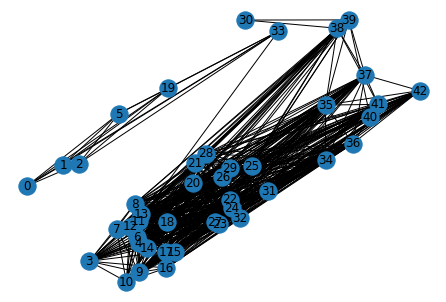

In [11]:
# TICLGraph
nx.draw(G, pos=pos, with_labels=True)

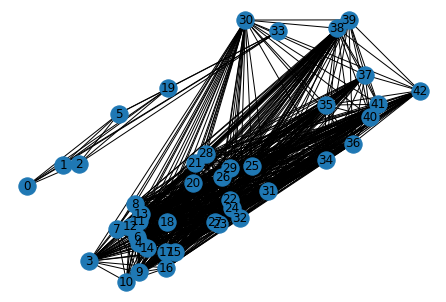

In [12]:
# Truth Graph
nx.draw(TruthG, pos=pos, with_labels=True)

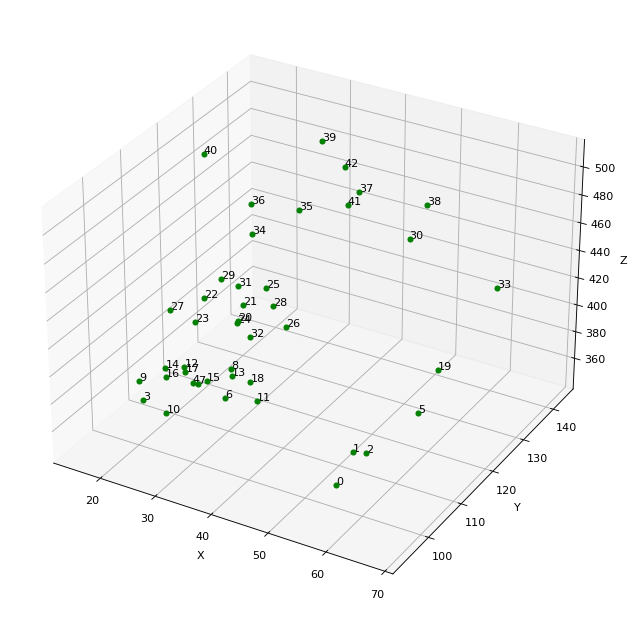

In [17]:
# CLUE3D Tracksters in 3D-cartesian coordinates
fig = plt.figure(figsize=(10,10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for i in range(tracksterN[event_to_visualize]):
    ax.scatter(x[event_to_visualize][i],y[event_to_visualize][i],z[event_to_visualize][i], color='g')
    ax.text(x[event_to_visualize][i],y[event_to_visualize][i],z[event_to_visualize][i], '%s' % (str(i)), zorder=1, color='k')
plt.show()

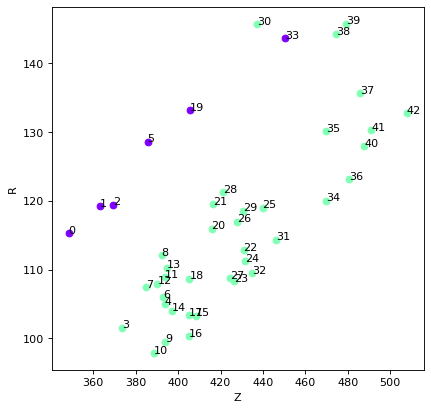

In [18]:
# in R-z, similar to the graph
fig = plt.figure(figsize=(6,6), dpi=80)
ax = fig.add_subplot()
ax.set_xlabel('Z')
ax.set_ylabel('R')
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=simTracksters_CP_N[event_to_visualize])

for i in range(tracksterN[event_to_visualize]):
    ax.scatter(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), color=cmap(norm(ts_best_matches[i])[1]))
    ax.text(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), '%s' %(str(i)), zorder=1, color='k')